Compare the downstream cellchat output of the covid balf dataset, rather than just the embedding (as done in cellchat_benchmark/05B), to get a better sense of the actual mechanistic differences in outputs. Focus on the "functional" analysis type. 

In [2]:
suppressPackageStartupMessages({
    library(CellChat, quietly = T)
    library(patchwork, quietly = T)
    library(RhpcBLASctl, quietly = T)
    library(Matrix, quietly = T)
    library(data.table, quietly = T)
    library(ggplot2, quietly = T)
})
options(stringsAsFactors = FALSE)
# RhpcBLASctl::blas_set_num_threads(25) # no multithreading

# paths
expression_data_path = '/data2/hratch/immune_CCI/covid/expression_data/covid_data/'#'/data2/eric/CCC-Benchmark/data/External/'
external_expression_path = F # set to T if using commented out path , small parsing differences

output_path = '/data2/hratch/immune_CCI/covid/balf_classification/'
rev_path = '/data3/hratch/tc2c_analyses_1/natcomm_revisions/'
input_data_path = '/data2/hratch/immune_CCI/covid/inputs/'

# parameters
type_<-'functional'#'structural'
group<-0
seed<-888
set.seed(seed)

if (external_expression_path){
    cell_grouper<-'cell_type'
}else{
    cell_grouper<-'celltype'
}

In [15]:
# do the downstream cellchat analysis of covid balf dataset with functional
# cellchat object originally generated in cellchat_benchmark/05B...
covid<-readRDS(paste0(rev_path, 'interim/covid_balf_cellchat_', type_, '_',
                               1, '.rds'))

# manually set embeddings to version 0 (see 05B markdown for details as to why)
# load version 0 embeddings, format for cellchat object, and overwrite current embeddings
embed_path = '/data2/hratch/immune_CCI/covid/balf_classification/'
embed<-read.csv(paste0(embed_path, 'cellchat_embeddings_balf_', type_, '_',  0, '.csv'))
embed<-embed[c('UMAP1', 'UMAP2', 'Sample', 'Signalling.Pathway')]
rownames(embed)<-paste(embed$Signalling.Pathway, embed$Sample, sep = '--')
embed<-as.matrix(embed[c('UMAP1', 'UMAP2')])
covid@netP$similarity[[type_]]$dr[[1]]<-embed

In the merged cellchat object, we choose just 3 samples: C51 representing a healthy control, C141 representing a moderate covid case, and C143 representing a severe case. 

In [108]:
samples<-rep(NA, 3)
names(samples)<-c('C51', 'C141', 'C143')
comparisons<-sapply(names(samples), function(n) which(names(covid@net) == n))
combinations<-combn(comparisons, 2)
comparisons<-setNames(names(comparisons), comparisons)

In [135]:
h_ = 20
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         legend.title=element_text(size=22), 
              plot.title = element_text(size = 20, hjust = 0.5), legend.position="none")

plots<-list()
for (col in (1:dim(combinations)[[2]])){
    comparison<-comparisons[as.character(combinations[,col])]
    g<-netVisual_bubble(covid,  comparison = as.numeric(names(comparison)), angle.x = 45) + 
    ggtitle(paste0(comparison, collapse = ' vs ')) + theme
    
    plots[[col]]<-g
}


Comparing communications on a merged object 


Comparing communications on a merged object 


Comparing communications on a merged object 




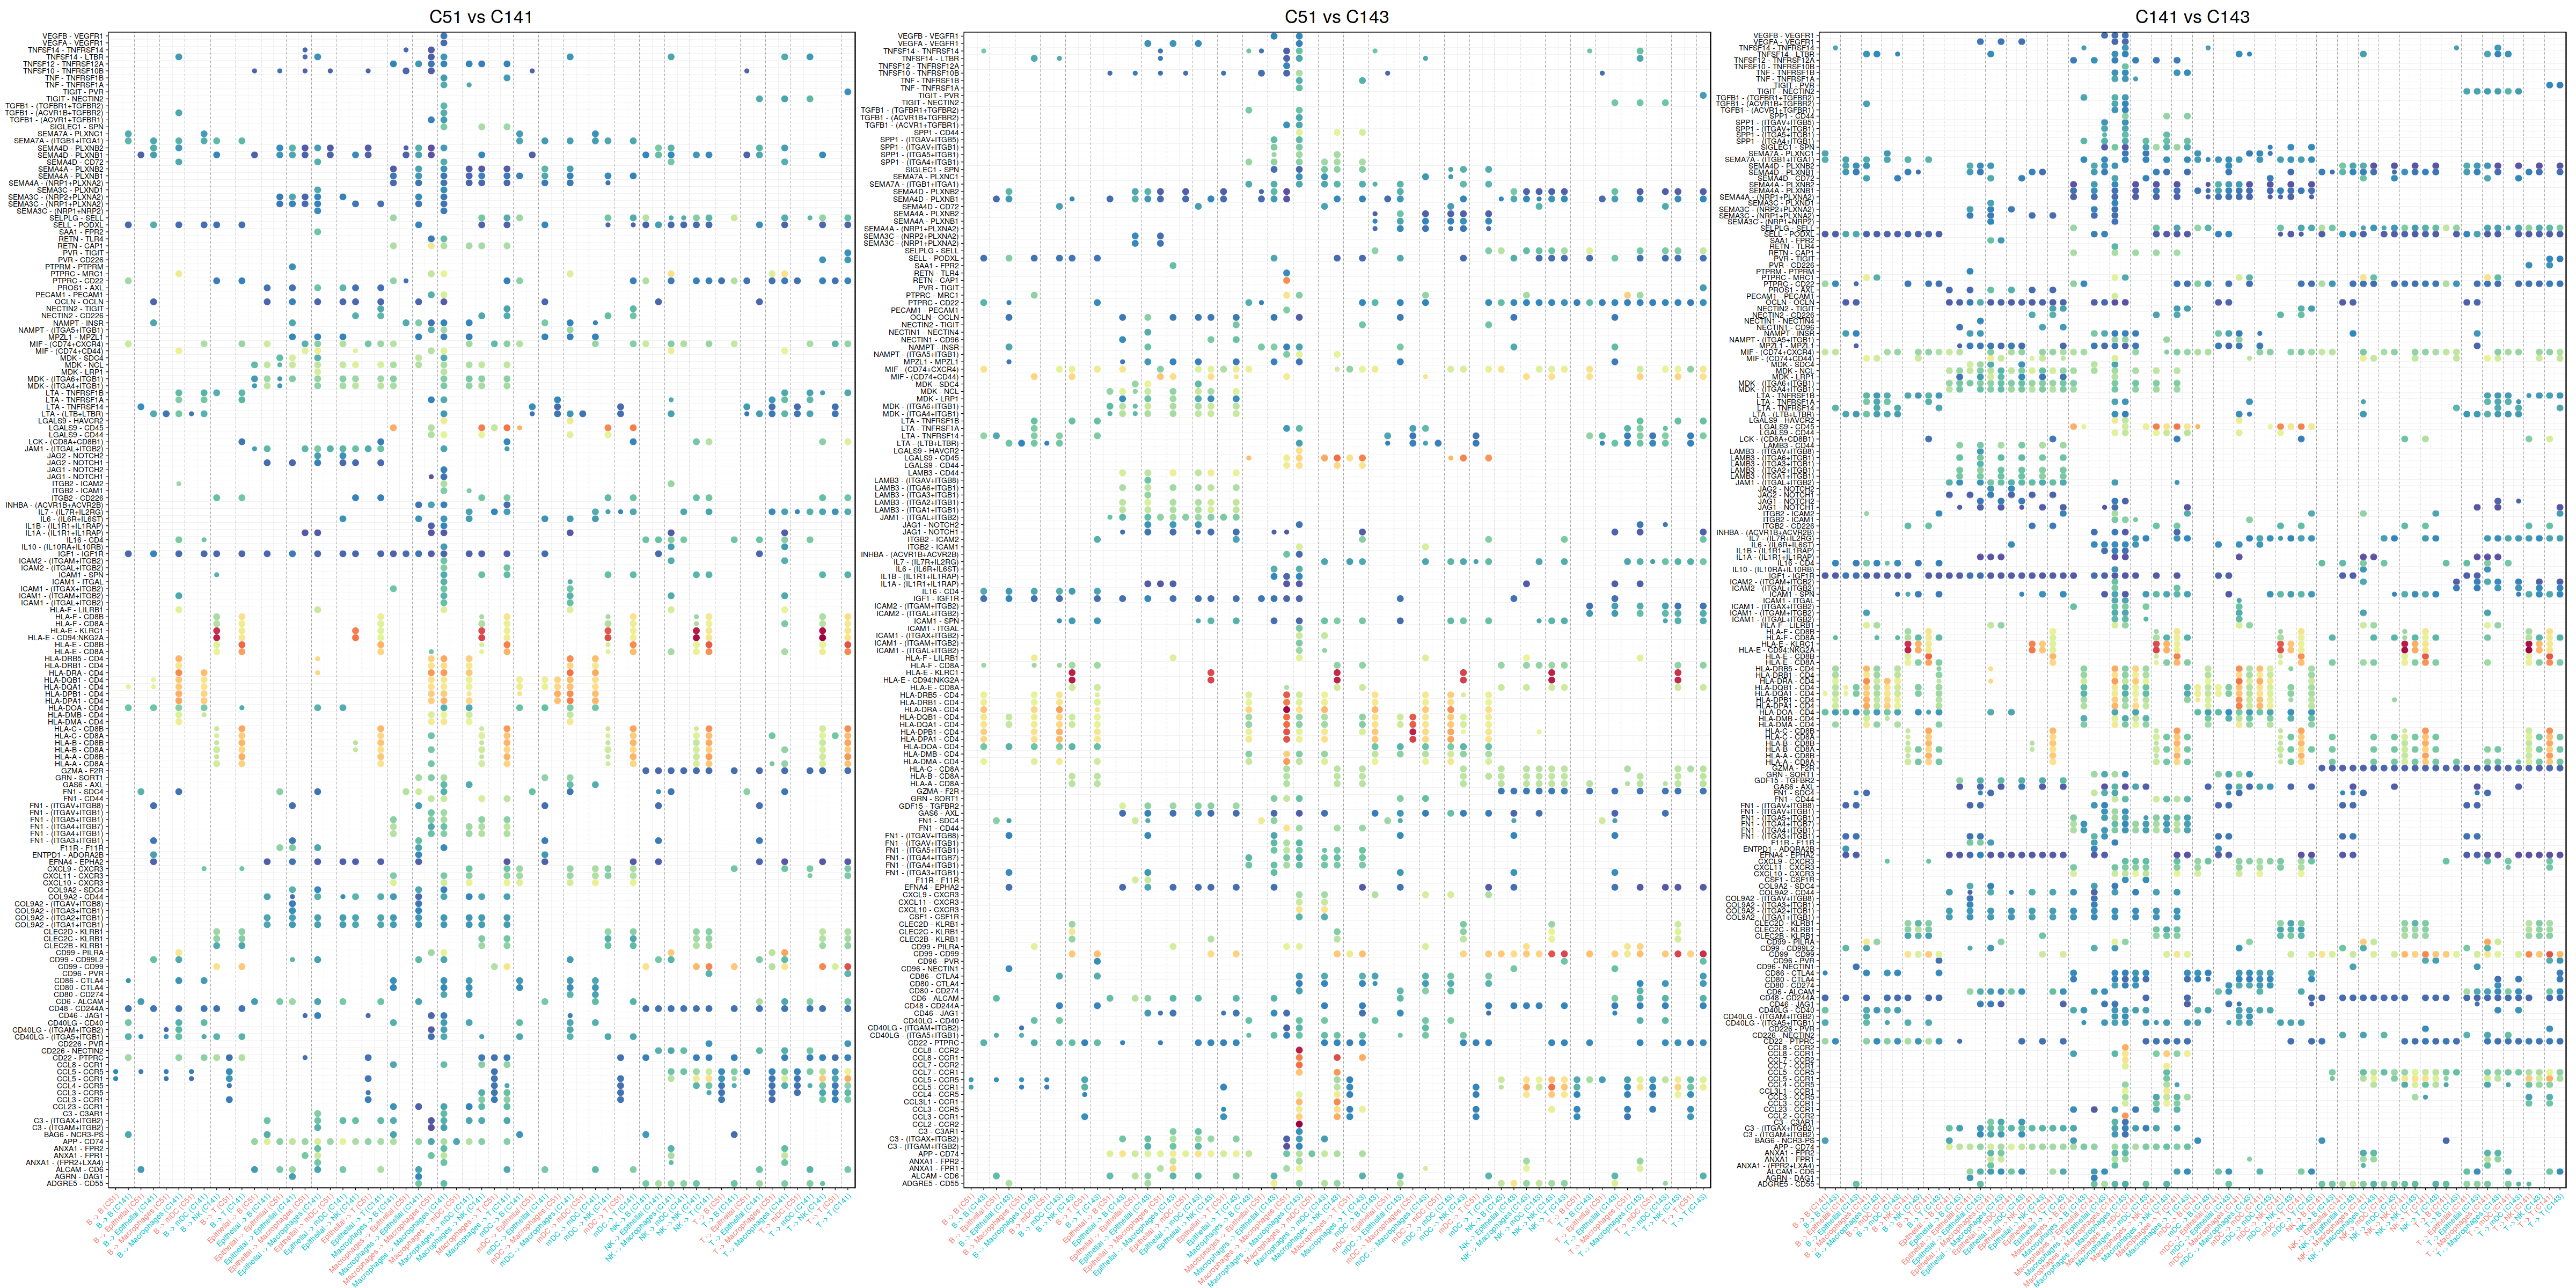

In [137]:
h_ = 20
w_ = 40
options(repr.plot.height=h_, repr.plot.width=w_)
plots[[1]] + plots[[2]] + plots[[3]]

In [138]:
embed_path = '/data2/hratch/immune_CCI/covid/balf_classification/'
embed<-read.csv(paste0(embed_path, 'cellchat_embeddings_balf_', type_, '_',  0, '.csv'))
embed<-embed[c('UMAP1', 'UMAP2', 'Sample', 'Signalling.Pathway')]
rownames(embed)<-paste(embed$Signalling.Pathway, embed$Sample, sep = '--')
embed<-as.matrix(embed[c('UMAP1', 'UMAP2')])
covid@netP$similarity[[type_]]$dr[[1]]<-embed

Classification learning of the signaling networks for datasets 1 2 3 4 5 6 7 8 9 10 11 12 
2D visualization of signaling networks from datasets 1 2 3 4 5 6 7 8 9 10 11 12 


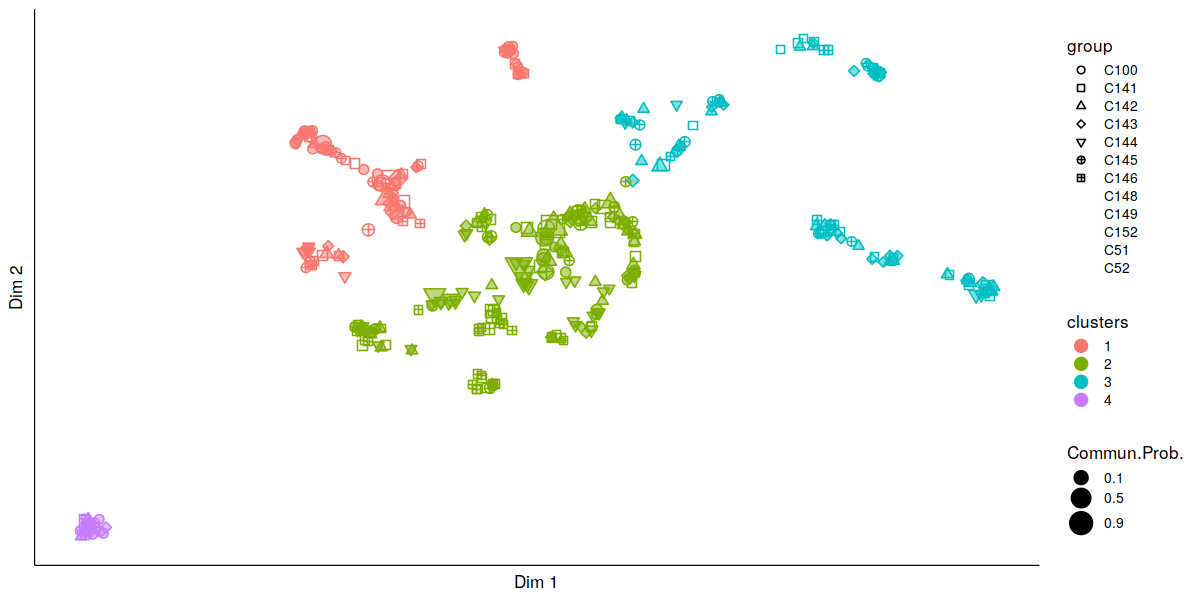

In [147]:
h_ = 5
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)
covid <- netClustering(covid, type = "functional")
netVisual_embeddingPairwise(covid, type = type_, label.size = 3.5)